In [17]:
# Code edited from Dario's cost-of-chemical-space project 

import pandas as pd
import sqlite3
from functools import reduce
from itertools import islice
import pickle
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import seaborn as sns

In [2]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rcParams.update({'font.size': 18})

## Read in Reaxys database

SQLite access to locally downloaded Reaxys database (from Dario)

In [8]:
conn = sqlite3.connect("C:\\Users\\group\\Desktop\\full_molecules.db")
first_line = pd.read_sql_query("""SELECT * FROM molecules LIMIT 1""", conn)
conn.close()
print(first_line)

           smiles reaxys_id                          name  formula       MW  \
0  CC(I)CC1CCCCN1      1267  2-(2-Iodo-propyl)-piperidine  C8H16IN  253.126   

    CAS bioactivity availability as_product                    InChI_key  \
0  None           0            0          0  LADXKDUENYZGKB-UHFFFAOYSA-N   

  markush_count n_references ma_publication_year  entry_date update_date  \
0             0            6                1970  1988/06/27  2022/03/24   

  as_reagent as_reagent_reactions  
0       None                 None  


In [4]:
conn = sqlite3.connect("C:\\Users\\group\\Desktop\\full_molecules.db")
df = pd.read_sql_query("""SELECT smiles, InChI_key, reaxys_id, n_references, name, as_reagent, as_product FROM molecules""", conn)
conn.close()
print(df)

## Read in SureChemBL database

Test: Read in a subset of the SureChemBL database to find smiles which can be linked with Reaxys

Eventual goal - apply this over entire SureChemBL database

In [13]:
#Test a subset of SureChemBL
fp = "G:\\Shared drives\\SureChemBL_Patents\\Cpd_Data\SureChEMBL_20141001_1.txt"
surechembl_df = pd.read_csv(fp, sep='\t')
print(surechembl_df)

          SureChEMBL_ID                                             SMILES  \
0              SCHEMBL4                   C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O   
1              SCHEMBL9  O=C(O)\C=C/C(=O)O.CCOC(=O)[C@H](CCC1=CC=CC=C1)...   
2             SCHEMBL10  OC(=O)C=CC(O)=O.CCOC(=O)[C@H](CCC1=CC=CC=C1)N[...   
3             SCHEMBL11  CC\C=C\C1=NC(Cl)=C(C=O)N1CC1=CC=C(C=C1)C1=C(C=...   
4             SCHEMBL12  CC=CCC1=NC(Cl)=C(C=O)N1CC1=CC=C(C=C1)C1=C(C=CC...   
...                 ...                                                ...   
7157446  SCHEMBL7999995             CCCCC1=CC2=CC=CC=C2C(OCC(CCN)N(C)C)=N1   
7157447  SCHEMBL7999997  CCCCCCCCCCCCCCCC(CC)NC(C(C)C)C1=CC2=C(C=CC(C)(...   
7157448  SCHEMBL7999998  COC1=C(F)C(C)=NC(=N1)N1C[C@H]2C(=O)N(C)C(=N)N[...   
7157449  SCHEMBL7999999  CCCCCCOC1=C(OC(C)C)C(=O)N(CCCCCC)C2=C1C=CC(NC(...   
7157450  SCHEMBL8000000  COC1=C2C3=C(NC(=O)C2=CC=C1)SC(CN1CCC[C@@H]1C(F...   

                                                     InChI  \
0

In [14]:
surechembl_df = surechembl_df.rename(columns={"InChIKey":"InChI_key"})

          SureChEMBL_ID                                             SMILES  \
0              SCHEMBL4                   C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O   
1              SCHEMBL9  O=C(O)\C=C/C(=O)O.CCOC(=O)[C@H](CCC1=CC=CC=C1)...   
2             SCHEMBL10  OC(=O)C=CC(O)=O.CCOC(=O)[C@H](CCC1=CC=CC=C1)N[...   
3             SCHEMBL11  CC\C=C\C1=NC(Cl)=C(C=O)N1CC1=CC=C(C=C1)C1=C(C=...   
4             SCHEMBL12  CC=CCC1=NC(Cl)=C(C=O)N1CC1=CC=C(C=C1)C1=C(C=CC...   
...                 ...                                                ...   
7157446  SCHEMBL7999995             CCCCC1=CC2=CC=CC=C2C(OCC(CCN)N(C)C)=N1   
7157447  SCHEMBL7999997  CCCCCCCCCCCCCCCC(CC)NC(C(C)C)C1=CC2=C(C=CC(C)(...   
7157448  SCHEMBL7999998  COC1=C(F)C(C)=NC(=N1)N1C[C@H]2C(=O)N(C)C(=N)N[...   
7157449  SCHEMBL7999999  CCCCCCOC1=C(OC(C)C)C(=O)N(CCCCCC)C2=C1C=CC(NC(...   
7157450  SCHEMBL8000000  COC1=C2C3=C(NC(=O)C2=CC=C1)SC(CN1CCC[C@@H]1C(F...   

                                                     InChI  \
0

## SureChemBL/Reaxys analysis

Combine & analyze the two databases

In [56]:
dataframes = [df, surechembl_df]
combined_df = reduce(lambda left, right: pd.merge(left, right, on=["InChI_key"], how="inner"), dataframes)
print(combined_df.head())

             smiles                    InChI_key reaxys_id n_references  \
0    CC(O)CN1CCCCC1  UCASFSAKVJTSET-UHFFFAOYSA-N      1268           56   
1     CCCC1CCCCN1CC  WIIWOZRNGAHZGW-UHFFFAOYSA-N      1272            1   
2  CC1CN(C)CC(C)N1C  XVJRVYONDJGSLX-UHFFFAOYSA-N      1273           16   
3      OCCCN1CCCCC1  PLRXAFVBCHEMGD-UHFFFAOYSA-N      1275          208   
4    CC1CCCN(CCO)C1  CAMLJDZKPYMXOK-UHFFFAOYSA-N      1278            4   

                                  name as_reagent as_product   SureChEMBL_ID  \
0         1-Piperidin-1-yl-propan-2-ol       None         14   SCHEMBL862327   
1          1-Ethyl-2-propyl-piperidine       None          0  SCHEMBL1275000   
2       1,2,4,6-Tetramethyl-piperazine       None          0    SCHEMBL81109   
3                                   na       None         16     SCHEMBL9400   
4  2-(3-Methyl-piperidin-1-yl)-ethanol       None          2    SCHEMBL13003   

             SMILES                                              InC

In [57]:
#Try to add degrees to this combined dataframe...
fp = "G:\\Shared drives\\SureChemBL_Patents\\Degrees\\Months\\IdDegrees\\id_degrees_2019-12.p"
id_degrees = pickle.load(file=open(fp, "rb"))
print(type(id_degrees))

print(list(islice(id_degrees.items(), 10)))

<class 'dict'>
[('SCHEMBL18007617', 801), ('SCHEMBL19276898', 162), ('SCHEMBL24290', 917), ('SCHEMBL2945027', 938), ('SCHEMBL31363', 603), ('SCHEMBL2127406', 533), ('SCHEMBL79611', 364), ('SCHEMBL343756', 104), ('SCHEMBL12205249', 359), ('SCHEMBL1725161', 52)]


In [58]:
id_degree_df = pd.DataFrame(list(id_degrees.items()), columns=["SureChEMBL_ID", "degree"])
print(id_degree_df)

         SureChEMBL_ID  degree
0      SCHEMBL18007617     801
1      SCHEMBL19276898     162
2         SCHEMBL24290     917
3       SCHEMBL2945027     938
4         SCHEMBL31363     603
...                ...     ...
93695    SCHEMBL290836     411
93696     SCHEMBL20977     238
93697  SCHEMBL21599701    1458
93698  SCHEMBL21602312    1060
93699  SCHEMBL21600585     617

[93700 rows x 2 columns]


In [59]:
dataframes = [combined_df, id_degree_df]
full_df = reduce(lambda left, right: pd.merge(left, right, on=["SureChEMBL_ID"], how="inner"), dataframes)
print(full_df.columns)

Index(['smiles', 'InChI_key', 'reaxys_id', 'n_references', 'name',
       'as_reagent', 'as_product', 'SureChEMBL_ID', 'SMILES', 'InChI',
       'degree'],
      dtype='object')


In [70]:
full_df["n_references"] = pd.to_numeric(full_df["n_references"])
full_df["as_reagent"] = pd.to_numeric(full_df["as_reagent"])
full_df["as_product"] = pd.to_numeric(full_df["as_product"])

Text(0, 0.5, 'N_Products')

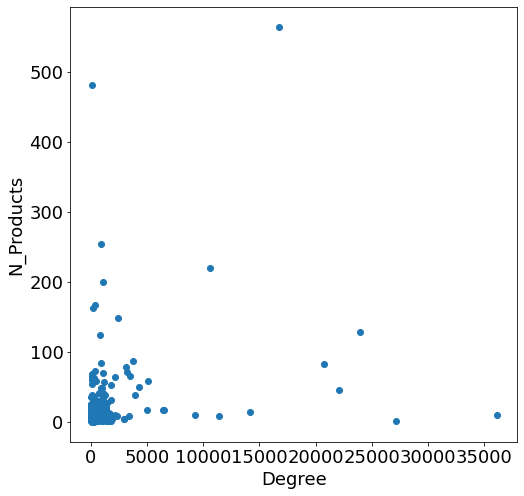

In [75]:
plt.figure(figsize=(8,8))
plt.scatter(full_df.degree, full_df.as_product)

plt.xlabel("Degree")
plt.ylabel("N_Products")

Text(0, 0.5, 'N_Products')

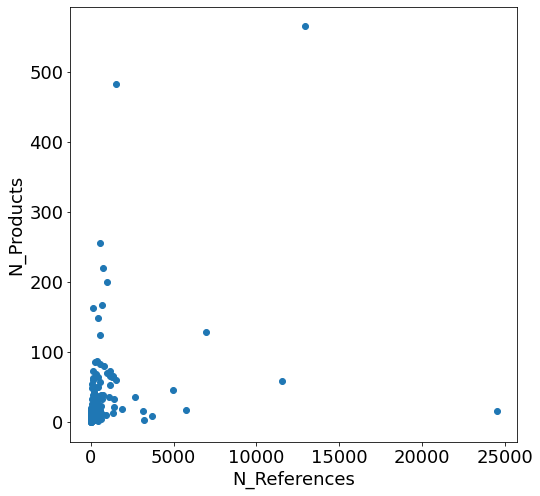

In [74]:
plt.figure(figsize=(8,8))
plt.scatter(full_df.n_references, full_df.as_product)

plt.xlabel("N_References")
plt.ylabel("N_Products")

## Random Reaxys MA 

Open Q: what was the criteria for selecting these? What kind of metadata do I have?

In [3]:
#Get MA values
def get_MA(fp):
    """ Get AssemblyGo MA value

    Args:
        fp (str): filepath to a particular .txt AssemblyGo output file

    Returns:
        label (str): label of the compound which was analzyed
        MA (int): assemblyGo MA value
        time (float): how much time it took to complete each MA run
    """
    with open(fp) as f:
        lines = f.readlines()

    try:
        #molfile will be the last element in 0th line
        label = lines[0].split()[-1].split("/")[-1].split(".")[0]

        #MA will be last elemnt in -2nd line (will be an int)
        MA = int(lines[-2].split()[-1])

        time = float(lines[-1].split()[-1])
        
        return label, MA, time

    except:
        return None, None, None



In [8]:
#Get list of MA values, create a pandas dataframe of label/MA values
fp = "Data/AssemblyValues/ReaxysRandom_Done/ReaxysRandom_Done/"
result_files = [x for x in os.listdir(fp) if x.endswith(".txt")]

results = []
for f in tqdm(result_files):
    label, MA, time = get_MA(fp + f)
    results.append({"label": label, "MA": MA, "time": time})
    

100%|██████████| 79873/79873 [00:12<00:00, 6287.48it/s]


In [9]:
results_df = pd.DataFrame(results)
print(results_df)

          label    MA        time
0      10757719  17.0  300.914381
1       5380159  29.0  299.824537
2      31671536  29.0  299.933365
3      10975189  12.0  106.447870
4      34942307  19.0  300.748215
...         ...   ...         ...
79868  24689744  19.0  300.139830
79869  27396869  15.0    1.379475
79870   7386348   9.0    0.110438
79871    819170  20.0  300.043927
79872  26189414  12.0   75.268518

[79873 rows x 3 columns]


63.0


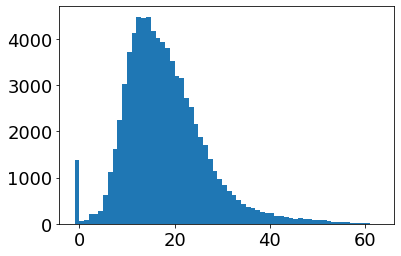

In [17]:
max_value = max(results_df["MA"])
print(max_value)

plt.hist(results_df["MA"], bins=int(max_value + 1)) #+1 to account for -1 values, probably should be removed

plt.show()

## Product / MA correlation

Test correlation between the number of times a compound has been used a product & its MA

In [3]:
#Get MA values
def get_MA(fp):
    """ Get AssemblyGo MA value

    Args:
        fp (str): filepath to a particular .txt AssemblyGo output file

    Returns:
        label (str): label of the compound which was analzyed
        MA (int): assemblyGo MA value
        time (float): how much time it took to complete each MA run
    """
    with open(fp) as f:
        lines = f.readlines()

    try:
        #molfile will be the last element in 0th line
        label = lines[0].split()[-1].split("/")[-1].split(".")[0]

        #MA will be last elemnt in -2nd line (will be an int)
        MA = int(lines[-2].split()[-1])

        time = float(lines[-1].split()[-1])
        
        return label, MA, time

    except:
        return None, None, None



### Product - Percentile Sampling

Randomly sampling 1.1k compounds from each percentile of as_product value (110k total) _(double check this explanation)_

In [5]:
#Get list of MA values, create a pandas dataframe of label/MA values
fp = "Data/AssemblyValues/ReaxysProductPercentiles_Done/"
result_files = [x for x in os.listdir(fp) if x.endswith(".txt")]

results = []
for f in tqdm(result_files):
    label, MA, time = get_MA(fp + f)
    results.append({"label": label, "MA": MA, "time": time})

results_df = pd.DataFrame(results)
results_df = results_df.dropna() #Drop failed runs (only 24 failed)
results_df = results_df.astype({"label":"int"})

print(results_df)

100%|██████████| 107065/107065 [00:18<00:00, 5783.83it/s]


           label    MA        time
0       21492269  16.0  299.951593
1       33834544  34.0  299.812045
2       27861394  22.0  300.109963
3        8398932  19.0  299.848484
4        2845316   9.0  299.886260
...          ...   ...         ...
107060  33985194  37.0  300.021112
107061  30765101  23.0  300.998639
107062  17367493  10.0    2.309473
107063  11566658  25.0  300.443701
107064  25343839  17.0  299.959150

[106723 rows x 3 columns]


In [11]:
## Merge random cost sample & MA database
random_product_df = pd.read_csv("Data/Reaxys/random_uniform_productPercentiles_110k.csv")
random_product_df = random_product_df.astype({"Unnamed: 0": "int"})

#print(random_cost_df.head())

full_df = random_product_df.merge(results_df, left_on="Unnamed: 0", right_on="label", how="outer")

print(full_df.head())
print(len(full_df))


   Unnamed: 0                                             smiles  \
0    16499686                                               None   
1    20538492                                               None   
2    20900895  CN(Cc1cccc(-c2cnc(OCc3ccncc3)nc2)c1)C(=O)CNC(=...   
3    22302622  Cc1cc(C(=O)C2CCN(c3ccc(S(=O)(=O)C4(C(=O)NO)CCN...   
4    36571584  COc1ccc(Nc2nccc(N3CCN(c4cccnc4)CC3)n2)cc1OCCCN...   

                     InChI_key  reaxys_id  n_references name  as_reagent  \
0  IKZRQTSKAQTYTJ-UHFFFAOYSA-N   17946361             1   na         NaN   
1                         None   22420508             1   na         NaN   
2  FQOCPFBRXNESBP-UHFFFAOYSA-N   22809928             1   na         NaN   
3  XOGRCGKEMDILIH-UHFFFAOYSA-N   24317262             3   na         NaN   
4  QABCKDQPDPCHSP-UHFFFAOYSA-N   40209338             1   na         NaN   

   as_product  product_percentile       label    MA        time  
0         1.0                   1         NaN   NaN         NaN  
1 

In [12]:
full_df = full_df.dropna(subset=["MA"])
print(full_df)

        Unnamed: 0                                             smiles  \
2         20900895  CN(Cc1cccc(-c2cnc(OCc3ccncc3)nc2)c1)C(=O)CNC(=...   
3         22302622  Cc1cc(C(=O)C2CCN(c3ccc(S(=O)(=O)C4(C(=O)NO)CCN...   
4         36571584  COc1ccc(Nc2nccc(N3CCN(c4cccnc4)CC3)n2)cc1OCCCN...   
5          3655241         CCOC(=O)C1C(C=C(C(F)(F)Cl)C(F)(F)Cl)C1(C)C   
6         12453836  CCCCCCCCCC[C@H]1CC[C@H](c2ccc(CCc3ccc(N=C=S)cc...   
...            ...                                                ...   
109995     1167203                               CCC1=CC(=O)C(C)(C)O1   
109996     7237635  NC(=O)c1cccc(CN2C(=O)N(Cc3cccc(C(N)=O)c3)[C@H]...   
109997     7176212  CCCC[C@@]1(OCSC)CC[C@@]2(CC[C@H](C)[C@@H](CCOC...   
109998     8061346  COc1ccc(OCOC[C@@H]2C[C@@](CCO[Si](c3ccccc3)(c3...   
109999    30103680  COc1cc2c(Oc3ccc(NC(=O)c4nn(-c5ccc(F)cc5)ccc4=O...   

                          InChI_key  reaxys_id  n_references  \
2       FQOCPFBRXNESBP-UHFFFAOYSA-N   22809928             

Text(0.5, 1.0, 'Reaxys Product/MA Test: 110k Compounds')

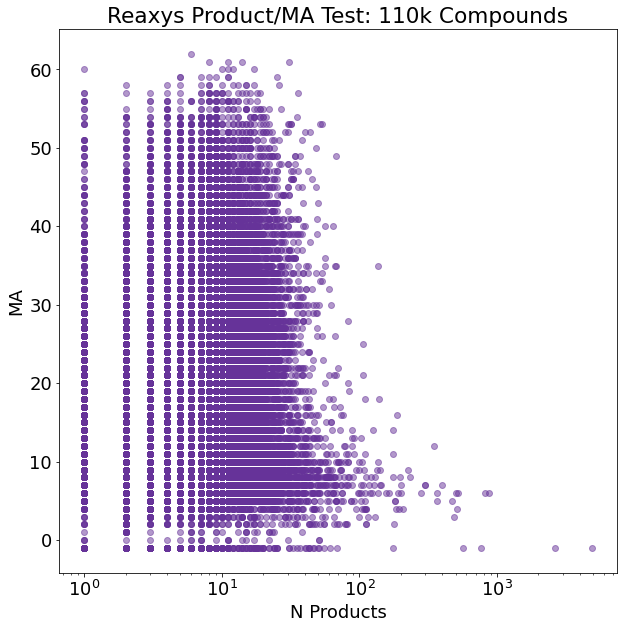

In [15]:
plt.figure(figsize=(10,10))

plt.scatter(full_df["as_product"], full_df["MA"], alpha=0.5, color="rebeccapurple")

plt.xscale("log")

plt.xlabel("N Products")
plt.ylabel("MA")
plt.title("Reaxys Product/MA Test: 110k Compounds")

In [16]:
timeFiltered_df = full_df[full_df["time"] <= 299]

print(len(timeFiltered_df))

33562


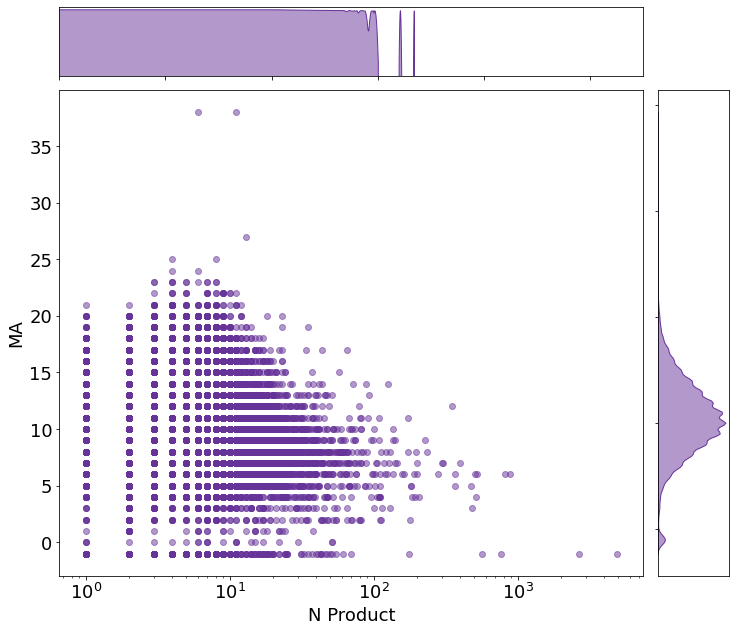

In [19]:
from matplotlib.gridspec import GridSpec

#Combine KDE & scatter plot
fig = plt.figure(figsize=(12,12))
gs = GridSpec(8,8)
ax_scatter = fig.add_subplot(gs[1:7, 0:7])
ax_hist_y = fig.add_subplot(gs[0,0:7])
ax_hist_x = fig.add_subplot(gs[1:7, 7])

#Scatter plot
ax_scatter.scatter(timeFiltered_df["as_product"], timeFiltered_df["MA"], alpha=0.5, color="rebeccapurple")
ax_scatter.set_xscale("log")
ax_scatter.set_xlabel("N Product")
ax_scatter.set_ylabel("MA")

#KDE distribution - price
sns.kdeplot(timeFiltered_df["as_product"], ax=ax_hist_y, color="rebeccapurple", fill=True, alpha=0.5)
ax_hist_y.tick_params(labelbottom=False, labelleft=False, left=False)
ax_hist_y.set_xlim(0.001, 1e8)
ax_hist_y.set_xlabel("")
ax_hist_y.set_ylabel("")
ax_hist_y.set_xscale("log")
ax_hist_y.set_yscale("log")

#KDE distribution - MA
sns.kdeplot(y = timeFiltered_df["MA"], ax=ax_hist_x, color="rebeccapurple", fill=True, alpha=0.5)

ax_hist_x.tick_params(labelbottom=False, labelleft=False, bottom=False)
ax_hist_x.set_xlabel("")
ax_hist_x.set_ylabel("")

plt.show()